In [1]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import h5py
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
import sys
sys.path.append('../')
import KMeans
%matplotlib inline
DIR_DATASET = "../data_set/"

In [2]:
filename = "N-CMAPSS_DS08c-008.h5"

In [3]:
def plot_df_color_per_unit(data, variables, labels, size=7, labelsize=17, option='Time', name=None):
    """
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        if n==0:
            ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

In [4]:
# Load data
with h5py.File(DIR_DATASET + filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))

W shape: (6417737, 4)
X_s shape: (6417737, 14)
X_v shape: (6417737, 14)
T shape: (6417737, 10)
A shape: (6417737, 4)


In [5]:
df_A = DataFrame(data=A, columns=A_var)
df_W = DataFrame(data=W, columns=W_var)
df_W['unit'] = df_A['unit'].values


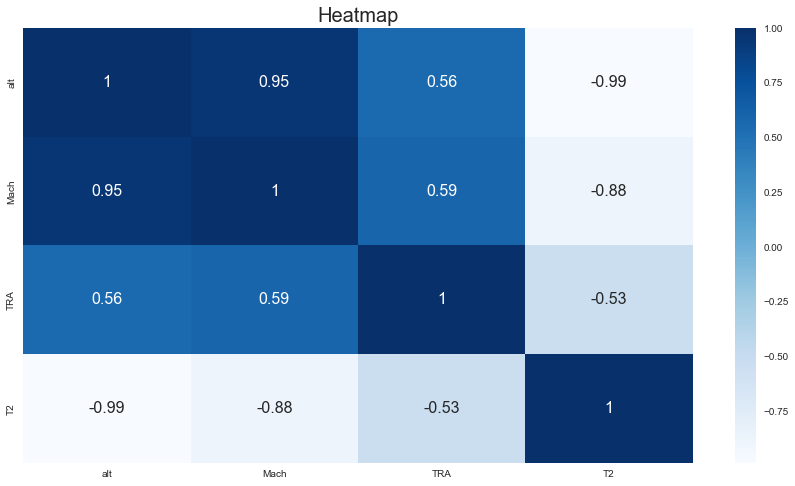

In [6]:
plt.figure(figsize=(15,8))
sns.heatmap(df_W.drop(["unit"], axis=1).corr(), cmap = 'Blues', annot = True, annot_kws={"fontsize": 16})
plt.title('Heatmap', fontsize = 20)

plt.show()

In [7]:
df_X_s = DataFrame(data=X_s, columns=X_s_var) 
df_X_s['unit'] = df_W['unit'].values
df_X_s['alt'] = df_W['alt'].values
df_X_s['Mach'] = df_W['Mach'].values
df_X_s['TRA'] = df_W['TRA'].values
df_X_s['T2'] = df_W['T2'].values
df_X_s['cycle'] = df_A['cycle'].values
df_X_s

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,cycle
0,623.703671,1497.961251,1905.748847,1297.155519,19.670090,14.300144,19.969635,25.048474,419.892878,426.471104,16.313650,2211.390744,8781.162212,5.065123,1.0,3008.0,0.350658,78.222099,520.434430,1.0
1,623.705184,1497.934281,1905.456402,1296.867930,19.667190,14.297018,19.966690,25.046456,419.823527,426.404057,16.307995,2211.587204,8781.150874,5.062908,1.0,3014.0,0.350658,78.222099,520.413179,1.0
2,623.519509,1496.404431,1901.169747,1294.120319,19.652891,14.298894,19.952174,25.019703,418.270660,424.864063,16.272197,2209.090201,8776.737611,5.030290,1.0,3022.0,0.351540,77.782646,520.445512,1.0
3,622.971839,1494.224129,1896.979472,1292.042214,19.613403,14.292765,19.912084,24.946426,416.112060,422.692585,16.238231,2204.109329,8769.890552,4.993672,1.0,3027.0,0.351036,77.255310,520.391947,1.0
4,622.443958,1491.877763,1892.301787,1289.679165,19.579963,14.295446,19.878135,24.877265,413.829157,420.399250,16.202249,2198.560497,8762.544928,4.954148,1.0,3038.0,0.352233,76.640076,520.438472,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6417732,580.874265,1336.311772,1632.337827,1190.588776,16.690469,13.544327,16.944638,19.784800,277.279021,282.288846,14.675413,1813.128361,8239.482286,2.887059,10.0,3015.0,0.212625,42.275089,512.509382,54.0
6417733,581.322145,1338.902762,1638.919473,1194.172451,16.710928,13.540672,16.965410,19.831510,279.330162,284.327816,14.706590,1819.208824,8247.658552,2.922004,10.0,3012.0,0.211302,42.890320,512.464381,54.0
6417734,581.779327,1339.878239,1638.680086,1192.984508,16.731720,13.540742,16.986518,19.878398,279.972724,285.006436,14.702330,1824.289040,8251.821581,2.925543,10.0,3009.0,0.210924,43.153988,512.459609,54.0
6417735,581.944856,1340.229350,1638.928107,1192.902754,16.741151,13.544101,16.996092,19.896491,280.223017,285.263575,14.704674,1825.730304,8253.061057,2.927910,10.0,3006.0,0.211428,43.241879,512.490731,54.0


In [8]:
#selezione unita e ciclo
unit=1
cycle=10

<Figure size 432x288 with 0 Axes>

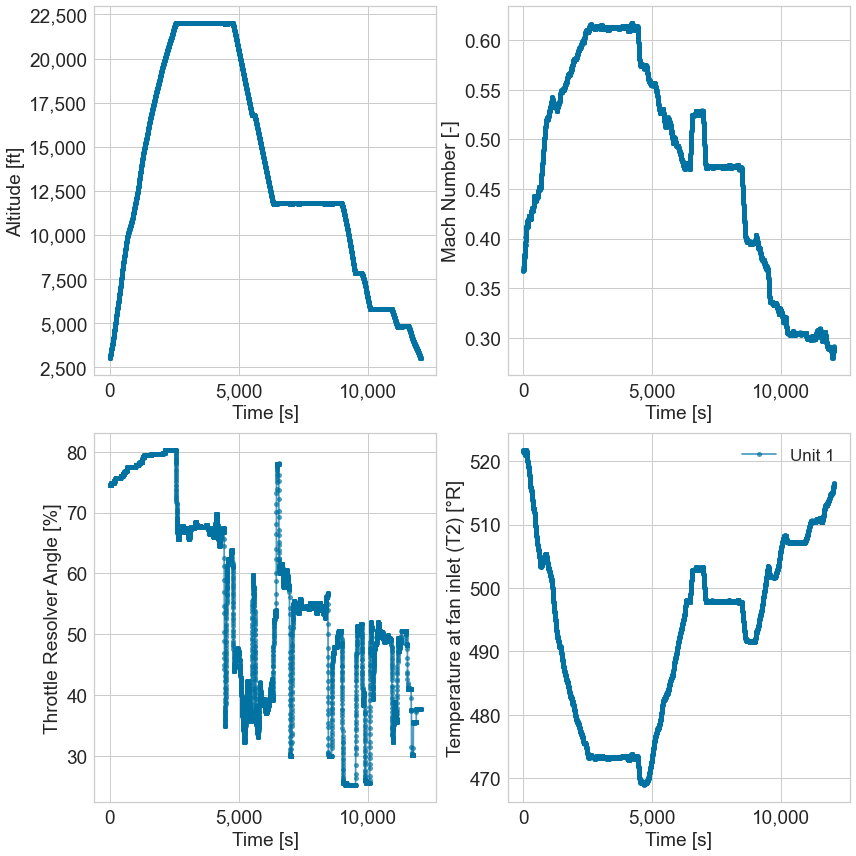

In [9]:
filter1 = df_X_s[df_X_s['unit']==unit]
filter1 = filter1[filter1['cycle']==cycle]
filter1.reset_index(inplace=True, drop=True)
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
plot_df_color_per_unit(filter1, W_var , labels, size=12, labelsize=19, name='./plot/flight_profile_'+ filename.replace('.h5','')+'_unit_'+str(unit)+'_cycle_'+str(cycle)+'.png')

In [10]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import root
x = np.array(np.arange(len(df_X_s)))
y = np.array(df_X_s['alt'].to_list())

# calcolare la derivata
dy_dx = np.gradient(y, x)

# trovare i punti stazionari
stationary_points = x[np.where(dy_dx == 0)[0]]

print(stationary_points)

df_X_s = df_X_s.iloc[stationary_points]
df_X_s.reset_index(inplace=True)

[   1967    1968    1980 ... 6417673 6417675 6417679]


<Figure size 432x288 with 0 Axes>

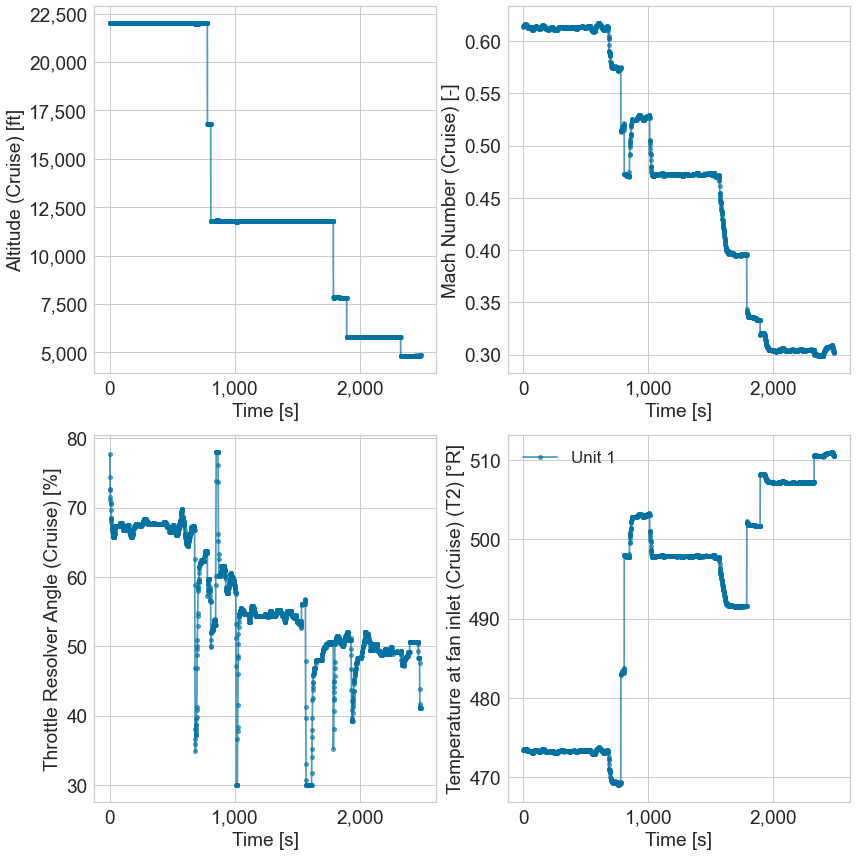

In [11]:
filter2 = df_X_s[df_X_s['unit']==unit]
filter2 = filter2[filter2['cycle']==cycle]
filter2.reset_index(inplace=True, drop=True)
labels = ['Altitude (Cruise) [ft]', 'Mach Number (Cruise) [-]', 'Throttle Resolver Angle (Cruise) [%]', 'Temperature at fan inlet (Cruise) (T2) [°R]']
plot_df_color_per_unit(filter2, W_var , labels, size=12, labelsize=19, name='./plot/flight_profile_'+ filename.replace('.h5','')+'_unit_'+str(unit)+'_cycle_'+str(cycle)+'_cruise_data.png')

## CLUSTERING

7.45636793571801e-16 1.0000000000000007
(800577, 19)


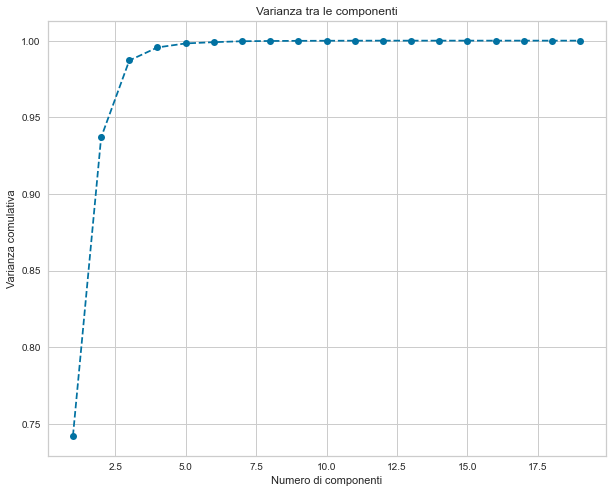

In [12]:
df_X_s_norm = KMeans.normalize_df(df_X_s.drop(columns=["unit",'cycle']))
KMeans.plot_variance_ratio(df_X_s_norm)

it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9
Numero di cluster (k-means): 2


KMeans(n_clusters=2, random_state=42)

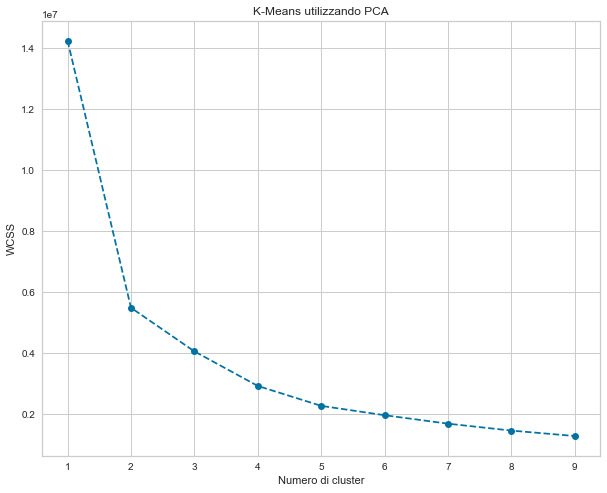

In [13]:
#prendiamo l'80% della varianza comulativa
scores_pca = KMeans.apply_pca(df_X_s_norm,2)
wcss = []
for i in range(1,10):
      kmeans_pca = KMeans.KMeans(n_clusters=i,init='k-means++',random_state=42)
      kmeans_pca.fit(scores_pca)
      wcss.append(kmeans_pca.inertia_)
      print("it",str(i))
plt.figure(figsize=(10,8))
plt.plot(range(1,10),wcss,marker='o',linestyle='--')
plt.title('K-Means utilizzando PCA')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
kl = KneeLocator(range(1,10),wcss,curve="convex",direction="decreasing")
print("Numero di cluster (k-means):",kl.elbow)
kmeans_pca = KMeans.KMeans(n_clusters=kl.elbow,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

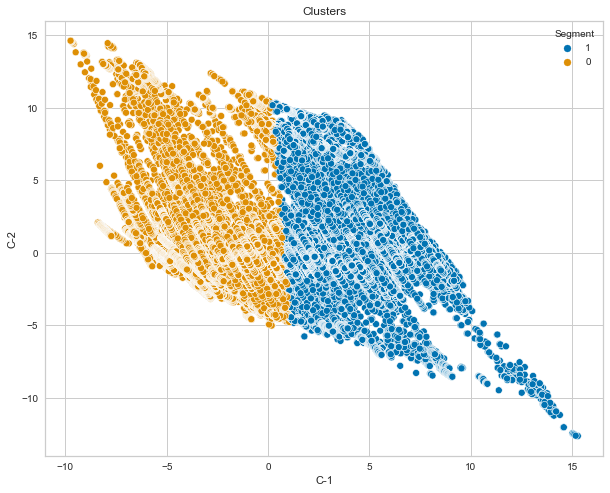

,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,unit,alt,Mach,TRA,T2,cycle,C-1,C-2,Segm K-means PCA,Segment
0,1967,577.415304,1376.388991,1724.100819,1148.054585,12.202814,9.018882,12.388643,15.589470,249.216143,...,1.0,18980.0,0.606816,76.288521,484.196528,1.0,1.682858,-3.560057,1,1
1,1968,577.034098,1375.056384,1722.768771,1147.863008,12.187568,9.021167,12.373165,15.557193,248.432872,...,1.0,18980.0,0.607131,75.936958,484.231571,1.0,1.646774,-3.473223,1,1
2,1980,572.230904,1353.637997,1680.737887,1126.762023,11.982578,9.033490,12.165054,15.146776,235.351548,...,1.0,18982.0,0.608958,70.311996,484.424309,1.0,0.896610,-1.850019,0,0
3,1981,571.758876,1351.448779,1676.650726,1124.769496,11.962207,9.034929,12.144373,15.106421,234.046515,...,1.0,18983.0,0.609210,69.784660,484.448244,1.0,0.822030,-1.689021,0,0
4,1985,570.446712,1346.377605,1668.339782,1121.384810,11.909343,9.037080,12.090703,14.997528,231.100711,...,1.0,18982.0,0.609462,68.554199,484.479345,1.0,0.659769,-1.325675,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800572,6417612,588.042816,1361.430683,1675.865651,1205.557945,17.121997,13.671209,17.382738,20.573460,296.954398,...,10.0,3135.0,0.255150,47.724270,514.093739,54.0,7.948606,0.173725,1,1
800573,6417639,571.891628,1290.621188,1543.166019,1152.735775,16.257810,13.650471,16.505391,18.856939,243.580590,...,10.0,3138.0,0.251118,32.255630,513.876238,54.0,5.332888,5.663698,1,1
800574,6417673,578.976794,1328.234177,1616.606602,1182.870653,16.540981,13.489181,16.792874,19.541589,270.533944,...,10.0,3195.0,0.221130,40.605179,512.237125,54.0,6.633220,2.727260,1,1
800575,6417675,578.943547,1328.235884,1616.975802,1183.216254,16.539206,13.488201,16.791072,19.537973,270.546408,...,10.0,3194.0,0.220815,40.605179,512.224683,54.0,6.636491,2.723824,1,1


In [14]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)
KMeans.view_kmeans_results_2d(df_segm_pca_kmeans,scores_pca,kmeans_pca)

In [15]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)

KMeans.calculate_centroids(df_segm_pca_kmeans,scores_pca,"",0)

-1.3693570038207227e-15 1.0000000000000002
(495191, 21)
-4.650216489659506e-16 1.0000000000000007
(305386, 21)


,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,cycle,group
mean,2.897869e+06,552.775082,1313.785701,1639.694605,1091.220246,9.708749,7.302181,9.856598,12.301335,191.713018,...,2039.689798,8186.423764,2.060150,4.526058,25222.297645,0.664589,72.382885,466.709050,27.786711,0.0
mean,3.407675e+06,578.632706,1346.265189,1646.395826,1151.629663,14.642821,11.582783,14.865808,17.838513,261.327648,...,1929.393915,8289.060467,2.759938,5.346709,10427.426984,0.460257,54.139863,502.614636,28.070920,1.0


Text(0, 0.5, 'Flight Class # [-]')

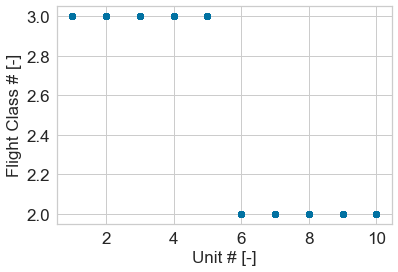

In [16]:
labelsize = 17
plt.plot(df_A.unit, df_A.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

In [17]:
dic = {}
for i in range(1,len(set(df_A.unit))+1):
    dic[i] = int(df_A[df_A.unit==i]["Fc"].iloc[0])
dic

{1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2}

In [18]:
df_segm_pca_kmeans['class'] = df_segm_pca_kmeans['unit'].map(dic)
df_segm_pca_kmeans

,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,alt,Mach,TRA,T2,cycle,C-1,C-2,Segm K-means PCA,Segment,class
0,1967,577.415304,1376.388991,1724.100819,1148.054585,12.202814,9.018882,12.388643,15.589470,249.216143,...,18980.0,0.606816,76.288521,484.196528,1.0,1.682858,-3.560057,1,1,3
1,1968,577.034098,1375.056384,1722.768771,1147.863008,12.187568,9.021167,12.373165,15.557193,248.432872,...,18980.0,0.607131,75.936958,484.231571,1.0,1.646774,-3.473223,1,1,3
2,1980,572.230904,1353.637997,1680.737887,1126.762023,11.982578,9.033490,12.165054,15.146776,235.351548,...,18982.0,0.608958,70.311996,484.424309,1.0,0.896610,-1.850019,0,0,3
3,1981,571.758876,1351.448779,1676.650726,1124.769496,11.962207,9.034929,12.144373,15.106421,234.046515,...,18983.0,0.609210,69.784660,484.448244,1.0,0.822030,-1.689021,0,0,3
4,1985,570.446712,1346.377605,1668.339782,1121.384810,11.909343,9.037080,12.090703,14.997528,231.100711,...,18982.0,0.609462,68.554199,484.479345,1.0,0.659769,-1.325675,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800572,6417612,588.042816,1361.430683,1675.865651,1205.557945,17.121997,13.671209,17.382738,20.573460,296.954398,...,3135.0,0.255150,47.724270,514.093739,54.0,7.948606,0.173725,1,1,2
800573,6417639,571.891628,1290.621188,1543.166019,1152.735775,16.257810,13.650471,16.505391,18.856939,243.580590,...,3138.0,0.251118,32.255630,513.876238,54.0,5.332888,5.663698,1,1,2
800574,6417673,578.976794,1328.234177,1616.606602,1182.870653,16.540981,13.489181,16.792874,19.541589,270.533944,...,3195.0,0.221130,40.605179,512.237125,54.0,6.633220,2.727260,1,1,2
800575,6417675,578.943547,1328.235884,1616.975802,1183.216254,16.539206,13.488201,16.791072,19.537973,270.546408,...,3194.0,0.220815,40.605179,512.224683,54.0,6.636491,2.723824,1,1,2


In [19]:
for i in range(0,3):
    filtered = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"]==i]
    contatori = filtered['class'].value_counts()
    df_contatori = pd.DataFrame({'Classe': contatori.index, 'Conteggio': contatori.values})
    print("cluster",i)
    print(df_contatori)
    print("totale cluster",i,":",df_contatori["Conteggio"].sum())


cluster 0
   Classe  Conteggio
0       3     343133
1       2     152058
totale cluster 0 : 495191
cluster 1
   Classe  Conteggio
0       3     157346
1       2     148040
totale cluster 1 : 305386
cluster 2
Empty DataFrame
Columns: [Classe, Conteggio]
Index: []
totale cluster 2 : 0


In [20]:
df_segm_pca_kmeans_f = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"] == 1]
df_W_u = df_segm_pca_kmeans_f[df_segm_pca_kmeans_f.unit == 8]
df_W_u.reset_index(inplace=True, drop=True)
df_W_u
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
#plot_df_color_per_unit(df_W_u, W_var , labels, size=12, labelsize=19, name='flight_profile_DS02_clustering.png')
print('min:',df_W_u['alt'].min())
print('max:',df_W_u['alt'].max())

min: 3001.0
max: 21020.0
